In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pickle
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.externals import joblib
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from nltk.corpus import stopwords
from collections import defaultdict, Counter

Populating the interactive namespace from numpy and matplotlib


/home/dgilberg/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [255]:
import warnings
warnings.filterwarnings('ignore')

## Table of Contents
* [Modeling](#modeling)
* [All Committees](#all_committees)
* [Evaluation](#eval)
* [Foreign Relations](#foreign_relations)
* [Testing](#testing)
* [Visuals](#visuals)

In [5]:
for dl in ["averaged_perceptron_tagger", "maxent_treebank_pos_tagger", "punkt", "maxent_ne_chunker", "words"]:
    nltk.download(dl)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dgilberg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/dgilberg/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/dgilberg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/dgilberg/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/dgilberg/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Modeling <a class="anchor" id="modeling"></a>

In [16]:
all_df = pd.read_pickle("/home/dgilberg/nlp_partisanship/data/all_committees.pkl")
all_df
recent_df = all_df[all_df.Year > 2011]
recent_df["Release"] = recent_df.apply(lambda row: row["Release"].strip(), axis=1)
recent_df = recent_df[recent_df.Release != '']

/home/dgilberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
my_stops = stopwords.words()
leg_df = pd.read_csv("data/legislators-current.csv")
last_names = [name.lower() for name in list(leg_df.last_name)]
my_stops += last_names
excess_words = ["statement", "congress", "senator", "senate", "congressman", "committee", "whether", "role","since",
               "united", "states", "well", "much", "department", "congress", "like", "senators", "two", "three",
               "mr", "ms", "chairman", "ranking", "member", "republicans", "democrats", "republican", "democratic",
               "democrat", "put", "going", "said", "needs" ,"see", "get", "back", "going", "way", "last", "could"]
my_stops += excess_words
all_releases = list(recent_df["Release"])
corpus = list()
lengths = defaultdict(int)
for index, release in enumerate(all_releases):
    sents = nltk.sent_tokenize(release)
    lengths[index] = len(sents)
    corpus += sents


In [156]:
committees = list(recent_df.Committee.unique())
com_words = []
for com in committees:
    com_words += com.split(" ")
    
[a.lower() for a in com_words]

['agriculture',
 'appropriations',
 'banking',
 'budget',
 'commerce',
 'finance',
 'foreign',
 'relations',
 'help',
 'small',
 'business',
 'environment',
 'energy',
 'homeland',
 'security']

In [18]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.01, stop_words=my_stops, 
                        token_pattern="\\b[a-z][a-z]+\\b", ngram_range=(1,2))

rel_tf = tfidf.fit_transform(corpus)

In [19]:
nmf = NMF(n_components=100, init="random", random_state=42)

rel_nmf = nmf.fit_transform(rel_tf)

In [20]:
rel_lengths = list(lengths.values())
counter = 0
rel_scores = list()
for index, length in enumerate(rel_lengths):
    end_point = counter + length
    test = rel_nmf[counter:end_point]
    test_avg = test.mean(axis=0)
    counter = end_point
    #print(counter)
    rel_scores.append(test_avg)

In [21]:
recent_df["Topic_Scores"] = list(rel_scores)

In [31]:
with open("/home/dgilberg/nlp_partisanship/data/df_150topics.pkl", "wb") as picklefile:
    pickle.dump(recent_df, picklefile)

In [3]:
nmf = joblib.load("/home/dgilberg/nlp_partisanship/data/100_topics.pkl")
tfidf = joblib.load("/home/dgilberg/nlp_partisanship/data/tfidf.pkl")

In [22]:
for topic_idx, topic in enumerate(nmf.components_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([tfidf.get_feature_names()[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic #0:
report released recent review change data agencies general oversight concerns
Topic #1:
help labor ensure better communities protect improve businesses workers hope
Topic #2:
continue ensure hope future oversight believe colleagues strong making costs
Topic #3:
could cost agreement costs future better increase additional dollars based
Topic #4:
system current improve better based part believe medicare transportation private
Topic #5:
may recent concerns current order vote additional agreement future request
Topic #6:
bill provides passed good vote related improve water protect jobs
Topic #7:
agency rule protection proposed review management water environment labor oversight
Topic #8:
full available vote hope review ensure natural resources week opportunity
Topic #9:
energy resources natural development research water infrastructure costs future cost
Topic #10:
need resources ensure order better future clear reform protect strong
Topic #11:
security medicare homeland security 

programs development spending medicare improve job critical research agencies based
Topic #96:
information data available additional request private better protect agencies related
Topic #97:
safety ensure improve oversight workers review protect concerns transportation protection
Topic #98:
process review part order making concerns ensure improve hope based
Topic #99:
work together hope colleagues better ensure good job pay improve


In [341]:
no_topics = str(nmf.n_components)
file_path = "{}_topics.pkl".format(no_topics)
#joblib.dump(clf, 'filename.pkl') 
joblib.dump(nmf, file_path)
tf_file = "home/dgilberg/nlp_partisanship/data"
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']

## Evaluation Methods <a class="anchor" id="eval"></a>

In [618]:
def get_rel_score(release):
    #print(len(release))
    try:
        sents = nltk.sent_tokenize(release)
    except:
        sents = list()
        
    if len(sents) > 0:
        sents_tf = tfidf.transform(sents)
        
        sents_nmf = nmf.transform(sents_tf)
       
        score = sents_nmf.mean(axis=0)
    else:
        score = [0]
    return list(score)

def get_rel_average(arr):
    final = list()
    for index, rel in enumerate(arr):
        #print(index)
        final.append(get_rel_score(rel))
    final = pd.DataFrame(final)
    return np.array(final.mean(axis=0))

def get_all_rel_scores(arr):
    final = list()
    for rel in arr:
        
        final.append(get_rel_score(rel))
    
    return final

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

def get_party_classification(party):
    if party == "Democratic":
        return 0
    else:
        return 1

def compare_parties(df):
    dem_df = df[df.Party == "Democratic"]
    rep_df = df[df.Party == "Republican"]
    dem_rel = get_rel_average(list(dem_df.Release))
    rep_rel = get_rel_average(list(rep_df.Release))
    dist = pairwise_distances(dem_rel.reshape(1,-1), rep_rel.reshape(1,-1), metric="cosine")
    return dist

def get_committee_average(df, committee):
    df = df[df.Committee == committee]
    rels = list(df.Release)
    return get_rel_average(rels)
    

def get_party_committee_score(df, party, committee):
    mask = (df.Committee == committee) & (df.Party == party)
    df = df[mask]
    rels = list(df.Release)
    return get_rel_average(rels)

def get_party_committee_year_score(df, party, committee, year):
    mask = (df.Committee == committee) & (df.Party == party) & (df.Year == year)
    df = df[mask]
    rels = list(df.Release)
    return get_rel_average(rels)

def get_committee_average_year(df, committee, year):
    mask = (df.Committee == committee) & (df.Year == year)
    df = df[mask]
    rels = list(df.Release)
    return get_rel_average(rels)


def get_party_committee_quarter_score(df, party, committee, year, quarter):
    mask = (df.Committee == committee) & (df.Party == party) & (df.Year == year) & (df.Quarter == quarter)
    df = df[mask]
    rels = list(df.Release)
    return get_rel_average(rels)

def get_committee_average_quarter(df, committee, year, quarter):
    mask = (df.Committee == committee) & (df.Year == year) & (df.Quarter == quarter)
    df = df[mask]
    rels = list(df.Release)
    return get_rel_average(rels)


In [602]:
def get_party_committee_distance(df, committee, year):
    test_gop = get_party_committee_year_score(recent_df, "Republican", committee, year)
    test_dem = get_party_committee_year_score(recent_df, "Democratic", committee, year)
    test_all = get_committee_average_year(recent_df, committee, year)
    dem_dist = pairwise_distances(test_dem.reshape(1,-1), test_all.reshape(1,-1), metric="cosine")[0][0]
    gop_dist = pairwise_distances(test_gop.reshape(1,-1), test_all.reshape(1,-1), metric="cosine")[0][0]
    print("Democratic Distance: {}".format(str(dem_dist)))
    print("Republican Distance: {}".format(str(gop_dist)))

In [615]:
mask = (recent_df.Party == "Republican") & (recent_df.Year == 2016) & (recent_df.Committee == "Budget")
recent_df[mask]

Committee       Date  Day               Label  Month       Party  \
2706    Budget 2016-12-19   19  Republican, Budget     12  Republican   
2707    Budget 2016-12-07    7  Republican, Budget     12  Republican   
2708    Budget 2016-11-30   30  Republican, Budget     11  Republican   
2709    Budget 2016-11-17   17  Republican, Budget     11  Republican   
2710    Budget 2016-10-20   20  Republican, Budget     10  Republican   
2711    Budget 2016-10-05    5  Republican, Budget     10  Republican   
2712    Budget 2016-09-29   29  Republican, Budget      9  Republican   
2713    Budget 2016-09-19   19  Republican, Budget      9  Republican   
2714    Budget 2016-09-14   14  Republican, Budget      9  Republican   
2715    Budget 2016-07-15   15  Republican, Budget      7  Republican   
2716    Budget 2016-07-13   13  Republican, Budget      7  Republican   
2717    Budget 2016-05-26   26  Republican, Budget      5  Republican   
2718    Budget 2016-05-25   25  Republican, Budget      5  Republican   
2719    Budget 2016-05-19   19  Republican, Budget      5  Republican   
2720    Budget 2016-05-18   18  Republican, Budget      5  Republican   
2721    Budget 2016-05-12   12  Republican, Budget      5  Republican   
2722    Budget 2016-05-12   12  Republican, Budget      5  Republican   
2723    Budget 2016-04-27   27  Republican, Budget      4  Republican   
2724    Budget 2016-04-22   22  Republican, Budget      4  Republican   
2725    Budget 2016-04-20   20  Republican, Budget      4  Republican   
2726    Budget 2016-04-18   18  Republican, Budget      4  Republican   
2727    Budget 2016-04-13   13  Republican, Budget      4  Republican   
2728    Budget 2016-04-13   13  Republican, Budget      4  Republican   
2729    Budget 2016-04-07    7  Republican, Budget      4  Republican   
2730    Budget 2016-04-06    6  Republican, Budget      4  Republican   
2731    Budget 2016-04-01    1  Republican, Budget      4  Republican   
2732    Budget 2016-03-09    9  Republican, Budget      3  Republican   
2733    Budget 2016-03-09    9  Republican, Budget      3  Republican   
2734    Budget 2016-03-08    8  Republican, Budget      3  Republican   
2735    Budget 2016-03-07    7  Republican, Budget      3  Republican   
2736    Budget 2016-02-17   17  Republican, Budget      2  Republican   
2737    Budget 2016-02-17   17  Republican, Budget      2  Republican   
2738    Budget 2016-02-11   11  Republican, Budget      2  Republican   
2739    Budget 2016-02-09    9  Republican, Budget      2  Republican   
2740    Budget 2016-02-04    4  Republican, Budget      2  Republican   
2741    Budget 2016-02-03    3  Republican, Budget      2  Republican   
2742    Budget 2016-02-03    3  Republican, Budget      2  Republican   
2743    Budget 2016-01-28   28  Republican, Budget      1  Republican   
2744    Budget 2016-01-20   20  Republican, Budget      1  Republican   
2745    Budget 2016-01-19   19  Republican, Budget      1  Republican   
2746    Budget 2016-01-19   19  Republican, Budget      1  Republican   
2747    Budget 2016-01-15   15  Republican, Budget      1  Republican   
2748    Budget 2016-01-12   12  Republican, Budget      1  Republican   
2749    Budget 2016-01-11   11  Republican, Budget      1  Republican   
2750    Budget 2016-01-06    6  Republican, Budget      1  Republican   
2751    Budget 2016-01-06    6  Republican, Budget      1  Republican   
2752    Budget 2016-01-06    6  Republican, Budget      1  Republican   
2753    Budget 2016-01-05    5  Republican, Budget      1  Republican   

                                                Release  \
2706  Enzi Statement On Trump Budget Director Nomine...   
2707  Enzi Unveils Reforms to Fix America’s Broken B...   
2708  GAO: Student Loan Cost Projections Doubled; Fl...   
2709  BUDGET BULLETIN: Regulatory Reform OutlookWASH...   
2710  BUDGET BULLETIN: FY 2017 Continuing Resolution...   
2711  New GAO Report Shows Feds Spend $1.5 Billion A...   
2712  GAO Rule

In [616]:
get_party_committee_distance(recent_df, "Budget", 2017)

Democratic Distance: 0.23453310114
Republican Distance: 0.0125433176224


In [25]:
def get_committee_distance_by_year(df, committee, year):
    mask = (df.Committee == committee) & (df.Year == year)
    df = df[mask]
    return compare_parties(df)

In [542]:
def get_all_committee_distances_year(df, year):
    temp = df[df.Year == year]
    committees = temp.Committee.unique()
    final = defaultdict()
    for c in committees:
        final[c] = get_committee_distance_by_year(temp, c, year)
    return final

In [554]:
def get_all_committee_distances_all_years(df):
    years = sorted(list(df.Year.unique()))
    print(years)
    comms = list(df.Committee.unique())
    final = defaultdict(list)
    for year in years:
        temp = df[df.Year == year]
        for c in committees:
            try:
                temp1 = temp[temp.Committee == c]
                num = compare_parties(temp1)
                final[c].append(num[0][0])
            except:
                final[c].append(None)
                
    rows = list()
    for arr in final.items():
        row = [arr[0], arr[1][0], arr[1][1], arr[1][2], arr[1][3], arr[1][4], arr[1][5]]
        rows.append(row)
        
    final_df = pd.DataFrame(rows, columns=["Committee", "2012", "2013", "2014", "2015", "2016", "2017"])
    return final_df
            

In [555]:
for dists_year = get_all_committee_distances_all_years(recent_df)

[2012, 2013, 2014, 2015, 2016, 2017]


In [566]:
years = range(2012, 2018)
for year in years:
    print(year)
    print(dists_year[["Committee", str(year)]].sort_values(str(year), ascending=False))

#dists_year.sort_values("2012", ascending=False)

2012
            Committee      2012
6   Foreign Relations  0.534532
3              Budget  0.443570
9         Environment  0.236446
0         Agriculture  0.198717
4            Commerce  0.114901
7                HELP  0.102597
10             Energy  0.071309
8      Small Business  0.023739
11  Homeland Security  0.013962
1      Appropriations       NaN
2             Banking       NaN
5             Finance       NaN
2013
            Committee      2013
3              Budget  0.277822
0         Agriculture  0.170916
9         Environment  0.164675
4            Commerce  0.132442
11  Homeland Security  0.122096
7                HELP  0.105737
2             Banking  0.093465
6   Foreign Relations  0.088542
5             Finance  0.061421
8      Small Business  0.050314
10             Energy  0.025116
1      Appropriations       NaN
2014
            Committee      2014
1      Appropriations  0.431970
0         Agriculture  0.395280
8      Small Business  0.324760
3              Budget  0.

In [546]:
get_all_committee_distances_year(recent_df, 2014)

defaultdict(None,
            {'Agriculture': array([[ 0.39527997]]),
             'Appropriations': array([[ 0.4319697]]),
             'Banking': array([[ 0.11916777]]),
             'Budget': array([[ 0.22760106]]),
             'Commerce': array([[ 0.07702659]]),
             'Energy': array([[ 0.16986053]]),
             'Environment': array([[ 0.1235843]]),
             'Finance': array([[ 0.05866355]]),
             'Foreign Relations': array([[ 0.13532846]]),
             'HELP': array([[ 0.13004202]]),
             'Homeland Security': array([[ 0.12519141]]),
             'Small Business': array([[ 0.3247595]])})

In [62]:
def get_committee_distance_by_quarter(df, committee, year, quarter):
    mask = (df.Committee == committee) & (df.Year == year) & (df.Quarter == quarter)
    df = df[mask]
    return compare_parties(df)

In [77]:
get_committee_distance_by_quarter(recent_df, "Agriculture", 2012, "Q1")

array([[ 0.32787844]])

In [83]:
def get_all_quarters(df):
    temp = df.groupby(["Committee", "Year", "Quarter", "Party"], as_index=False)["Release"].agg(lambda col: " ".join(col))
    all_quarters = list(zip(list(temp.Committee), list(temp.Year), list(temp.Quarter), list(temp.Party)))
    return all_quarters

In [187]:
def get_all_quarter_scores(df):
    all_quarters = list(zip(list(temp.Year), list(temp.Quarter)))
    return list(set(all_quarters))

In [191]:
get_all_quarter_scores(comm_quarter_scores)

[(2012, 'Q3')]

In [166]:
def get_committee_distances_by_quarter(df):
    al_quarters = get_all_quarter(df)
    quarter_scores = defaultdict()
    print(len(all_quarters))
    for index, quarter in enumerate(all_quarters):
        print(index)
        try:
            quarter_scores[(quarter[0], quarter[1], quarter[2])] = get_committee_distance_by_quarter(df, quarter[0], quarter[1], quarter[2])[0][0]
        except:
            quarter_scores[(quarter[0], quarter[1], quarter[2])] = 0
    rows = list()
    for score in list(quarter_scores.items()):
        committee = score[0][0]
        year = score[0][1]
        quarter = score[0][2]
        dist = score[1]
        row = [committee, year, quarter, dist]
        rows.append(row)
    df = pd.DataFrame(rows, columns=["Committee", "Year", "Quarter", "Score"])
    return df

In [160]:
recent_df

Committee       Date  Day                          Label  \
0            Agriculture 2017-11-09    9        Democratic, Agriculture   
1            Agriculture 2017-11-02    2        Democratic, Agriculture   
2            Agriculture 2017-11-01    1        Democratic, Agriculture   
3            Agriculture 2017-10-18   18        Democratic, Agriculture   
4            Agriculture 2017-10-17   17        Democratic, Agriculture   
5            Agriculture 2017-10-05    5        Democratic, Agriculture   
6            Agriculture 2017-09-28   28        Democratic, Agriculture   
7            Agriculture 2017-09-19   19        Democratic, Agriculture   
8            Agriculture 2017-09-14   14        Democratic, Agriculture   
9            Agriculture 2017-08-31   31        Democratic, Agriculture   
10           Agriculture 2017-08-25   25        Democratic, Agriculture   
11           Agriculture 2017-08-08    8        Democratic, Agriculture   
12           Agriculture 2017-07-27   27        Democratic, Agriculture   
13           Agriculture 2017-07-26   26        Democratic, Agriculture   
14           Agriculture 2017-07-25   25        Democratic, Agriculture   
15           Agriculture 2017-07-20   20        Democratic, Agriculture   
16           Agriculture 2017-07-20   20        Democratic, Agriculture   
17           Agriculture 2017-07-14   14        Democratic, Agriculture   
18           Agriculture 2017-07-13   13        Democratic, Agriculture   
19           Agriculture 2017-07-13   13        Democratic, Agriculture   
20           Agriculture 2017-06-29   29        Democratic, Agriculture   
21           Agriculture 2017-06-29   29        Democratic, Agriculture   
22           Agriculture 2017-06-22   22        Democratic, Agriculture   
23           Agriculture 2017-06-16   16        Democratic, Agriculture   
24           Agriculture 2017-06-15   15        Democratic, Agriculture   
25           Agriculture 2017-06-15   15        Democratic, Agriculture   
26           Agriculture 2017-06-09    9        Democratic, Agriculture   
27           Agriculture 2017-06-07    7        Democratic, Agriculture   
28           Agriculture 2017-05-30   30        Democratic, Agriculture   
29           Agriculture 2017-05-25   25        Democratic, Agriculture   
...                  ...        ...  ...                            ...   
17251  Homeland Security 2017-03-08    8  Republican, Homeland Security   
17252  Homeland Security 2017-03-06    6  Republican, Homeland Security   
17253  Homeland Security 2017-03-02    2  Republican, Homeland Security   
17254  Homeland Security 2017-03-01    1  Republican, Homeland Security   
17255  Homeland Security 2017-03-01    1  Republican, Homeland Security   
17256  Homeland Security 2017-02-28   28  Republican, Homeland Security   
17257  Homeland Security 2017-02-15   15  Republican, Homeland Security   
17258  Homeland Security 2017-02-15   15  Republican, Homeland Security   
17259  Homeland Security 2017-02-13   13  Republican, Homeland Security   
17260  Homeland Security 2017-02-08    8  Republican, Homeland Security   
17261  Homeland Security 2017-02-08    8  Republican, Homeland Security   
17262  Homeland Security 2017-02-02    2  Republican, Homeland Security   
17263  Homeland Security 2017-02-02    2  Republican, Homeland Security   
17264  Homeland Security 2017-02-01    1  Republican, Homeland Security   
17265  Homeland Security 2017-02-01    1  Republican, Homeland Security   
17266  Homeland Security 2017-01-30   30  Republican, Homeland Security   
17267  Homeland Security 2017-01-25   25  Republican, Homeland Security   
17268  Homeland Security 2017-01-24   24  Republican, Homeland Security   
17269  Homeland Security 2017-01-24   24  Republican, Homeland Security   
17270  Homeland Security 2017-01-24   24  Republican, Homeland Security   
17271  Homeland Security 2017-01-20   20  Republican, Homeland Security   
17272  Homeland Security 2017-01-18   18

In [211]:
def get_most_least_partisan_by_quarter(df):
    rows = list()
    all_quarters = set(list(zip(list(df.Year), list(df.Quarter))))
    for quarter in all_quarters:
        year = quarter[0]
        quart = quarter[1]
        mask = (df.Year == year) & (df.Quarter == quart)
        temp =  df[mask].sort_values("Score", ascending=False)
        temp = temp[temp.Score != 0]
        
        biggest_dist = list(temp.Committee)[0]
        biggest_score = list(temp.Score)[0]
        smallest_dist = list(temp.Committee)[-1]
        smallest_score = list(temp.Score)[-1]
        row = [year, quart, biggest_dist, biggest_score, smallest_dist, smallest_score]
        rows.append(row)
    final_df = pd.DataFrame(rows, columns=["Year", "Quarter", "Biggest_Difference_Committee", 
                                          "Biggest_Difference_Score", "Smallest_Distance_Committee",
                                          "Smallest_Distance_Score"])
    return final_df.sort_values(["Year", "Quarter"])
        
        

In [220]:
test = get_most_least_partisan_by_quarter(comm_quarter_scores)
test["Range"] = test.apply(lambda row: row["Biggest_Difference_Score"] - row["Smallest_Distance_Score"], axis = 1)
test.Smallest_Distance_Committee.value_counts()

Homeland Security    7
Small Business       5
Energy               4
Finance              3
HELP                 2
Commerce             1
Foreign Relations    1
Appropriations       1
Name: Smallest_Distance_Committee, dtype: int64

In [123]:
def get_committee_quarter_df(scores):
    rows = list()
    for score in list(scores.items()):
        committee = score[0][0]
        year = score[0][1]
        quarter = score[0][2]
        dist = score[1]
        row = [committee, year, quarter, dist]
        rows.append(row)
    df = pd.DataFrame(rows, columns=["Committee", "Year", "Quarter", "Score"])
    return df

In [53]:
get_committee_distances_by_quarter(recent_df, "Agriculture", 2015, "Q4")

          Committee  Year Quarter       Party  \
0       Agriculture  2012      Q1  Democratic   
1       Agriculture  2012      Q1  Republican   
2       Agriculture  2012      Q2  Democratic   
3       Agriculture  2012      Q2  Republican   
4       Agriculture  2012      Q3  Democratic   
5       Agriculture  2012      Q3  Republican   
6       Agriculture  2012      Q4  Democratic   
7       Agriculture  2012      Q4  Republican   
8       Agriculture  2013      Q1  Democratic   
9       Agriculture  2013      Q1  Republican   
10      Agriculture  2013      Q2  Democratic   
11      Agriculture  2013      Q2  Republican   
12      Agriculture  2013      Q3  Democratic   
13      Agriculture  2013      Q3  Republican   
14      Agriculture  2013      Q4  Democratic   
15      Agriculture  2013      Q4  Republican   
16      Agriculture  2014      Q1  Democratic   
17      Agriculture  2014      Q1  Republican   
18      Agriculture  2014      Q2  Democratic   
19      Agriculture 

In [26]:
def get_committee_distance_by_month(df, committee, year, month):
    mask = (df.Committee == committee) & (df.Year == year) & (df.Month == month)
    df = df[mask]
    return compare_parties(df)

In [39]:
def get_committee_distance_by_quarter(df, committee, year, quarter):
    mask = (df.Committee == committee) & (df.Year == year) & (df.Quarter == quarter)
    df = df[mask]
    return compare_parties(df)

In [30]:
def get_all_committee_year_scores(df):
    final = defaultdict()
    coms = df.Committee.unique()
    for com in coms:
        temp = df[df.Committee == com]
        years = temp.Year.unique()
        for year in years:
            print(com,year)
            temp1 = temp[temp.Year == year]
            if len(temp1.Party.unique()) >1:
                k = (com, year)
                final[k] = get_committee_distance_by_year(df, com, year)[0][0]
    return final

In [36]:
def get_quarter(month):
    months = list(range(1,13))
    quarters = [1,1,1,2,2,2,3,3,3,4,4,4]
    d = dict(zip(months,quarters))
    try:
        return "Q" + str(d[month])
    except:
        return ''
    


'Q1'

In [ ]:
def get_party_color("")

In [38]:
recent_df["Quarter"] = recent_df.apply(lambda row: get_quarter(row["Month"]), axis=1)
recent_df

Committee       Date  Day                          Label  \
0            Agriculture 2017-11-09    9        Democratic, Agriculture   
1            Agriculture 2017-11-02    2        Democratic, Agriculture   
2            Agriculture 2017-11-01    1        Democratic, Agriculture   
3            Agriculture 2017-10-18   18        Democratic, Agriculture   
4            Agriculture 2017-10-17   17        Democratic, Agriculture   
5            Agriculture 2017-10-05    5        Democratic, Agriculture   
6            Agriculture 2017-09-28   28        Democratic, Agriculture   
7            Agriculture 2017-09-19   19        Democratic, Agriculture   
8            Agriculture 2017-09-14   14        Democratic, Agriculture   
9            Agriculture 2017-08-31   31        Democratic, Agriculture   
10           Agriculture 2017-08-25   25        Democratic, Agriculture   
11           Agriculture 2017-08-08    8        Democratic, Agriculture   
12           Agriculture 2017-07-27   27        Democratic, Agriculture   
13           Agriculture 2017-07-26   26        Democratic, Agriculture   
14           Agriculture 2017-07-25   25        Democratic, Agriculture   
15           Agriculture 2017-07-20   20        Democratic, Agriculture   
16           Agriculture 2017-07-20   20        Democratic, Agriculture   
17           Agriculture 2017-07-14   14        Democratic, Agriculture   
18           Agriculture 2017-07-13   13        Democratic, Agriculture   
19           Agriculture 2017-07-13   13        Democratic, Agriculture   
20           Agriculture 2017-06-29   29        Democratic, Agriculture   
21           Agriculture 2017-06-29   29        Democratic, Agriculture   
22           Agriculture 2017-06-22   22        Democratic, Agriculture   
23           Agriculture 2017-06-16   16        Democratic, Agriculture   
24           Agriculture 2017-06-15   15        Democratic, Agriculture   
25           Agriculture 2017-06-15   15        Democratic, Agriculture   
26           Agriculture 2017-06-09    9        Democratic, Agriculture   
27           Agriculture 2017-06-07    7        Democratic, Agriculture   
28           Agriculture 2017-05-30   30        Democratic, Agriculture   
29           Agriculture 2017-05-25   25        Democratic, Agriculture   
...                  ...        ...  ...                            ...   
17251  Homeland Security 2017-03-08    8  Republican, Homeland Security   
17252  Homeland Security 2017-03-06    6  Republican, Homeland Security   
17253  Homeland Security 2017-03-02    2  Republican, Homeland Security   
17254  Homeland Security 2017-03-01    1  Republican, Homeland Security   
17255  Homeland Security 2017-03-01    1  Republican, Homeland Security   
17256  Homeland Security 2017-02-28   28  Republican, Homeland Security   
17257  Homeland Security 2017-02-15   15  Republican, Homeland Security   
17258  Homeland Security 2017-02-15   15  Republican, Homeland Security   
17259  Homeland Security 2017-02-13   13  Republican, Homeland Security   
17260  Homeland Security 2017-02-08    8  Republican, Homeland Security   
17261  Homeland Security 2017-02-08    8  Republican, Homeland Security   
17262  Homeland Security 2017-02-02    2  Republican, Homeland Security   
17263  Homeland Security 2017-02-02    2  Republican, Homeland Security   
17264  Homeland Security 2017-02-01    1  Republican, Homeland Security   
17265  Homeland Security 2017-02-01    1  Republican, Homeland Security   
17266  Homeland Security 2017-01-30   30  Republican, Homeland Security   
17267  Homeland Security 2017-01-25   25  Republican, Homeland Security   
17268  Homeland Security 2017-01-24   24  Republican, Homeland Security   
17269  Homeland Security 2017-01-24   24  Republican, Homeland Security   
17270  Homeland Security 2017-01-24   24  Republican, Homeland Security   
17271  Homeland Security 2017-01-20   20  Republican, Homeland Security   
17272  Homeland Security 2017-01-18   18

## All Committees <a class="anchor" id="all_committees"></a>

In [14]:
all_releases = list(recent_df.Release)

In [15]:
all_scores = list(recent_df.scores)

In [13]:
all_scores_df = pd.DataFrame(all_scores)
all_scores = all_scores_df.fillna(0)

In [87]:
all_tsne = TSNE(n_components=2)

In [19]:
colors = ["#BF7F3F", "#EECF13", "#054713", "#09EEF4", "#0930F4", "#060309", "#7B19DD", "#43FF7F", "#E51EB5",
         "#D3B0F6", "#696901", "#D10037"]

colors_dict = dict(zip(test, colors))

len(colors_dict)

12

In [20]:
all_df["color"] = all_df.apply(lambda row: colors_dict[row["Committee"]], axis=1)

In [77]:
colors_dict

{'Agriculture': '#BF7F3F',
 'Appropriations': '#EECF13',
 'Banking': '#054713',
 'Budget': '#09EEF4',
 'Commerce': '#0930F4',
 'Finance': '#060309',
 'Foreign Relations': '#7B19DD',
 'HELP': '#43FF7F',
 'Small Business': '#E51EB5'}

Agriculture: Beige/Brown

Appr: Yellow

Banking: Dark Green

Budget: Teal

Commerce: Blue

Finance: Black

Foreign Relations: Purple

HELP: light green

SB: Pink

In [96]:
all_results = all_tsne.fit_transform(all_scores)

all_x, all_y = get_coords(all_results)

In [97]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(list(recent_df.scores))

In [98]:
np.bincount(kmeans.labels_)

array([ 352,  720, 1300,  245,  502, 2632,  516,  377,  717, 4060,  718,
        244,   68,  304,  463])

In [99]:
recent_df["Cluster"] = list(kmeans.labels_)

In [31]:
test_cluster = recent_df[recent_df.Cluster == 5]
test_cluster_scores = list(test_cluster.scores)

In [281]:
scores_df = pd.DataFrame(rel_scores)
scores_df.loc[8, :].sum()

2.7891952040022203

/home/dgilberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


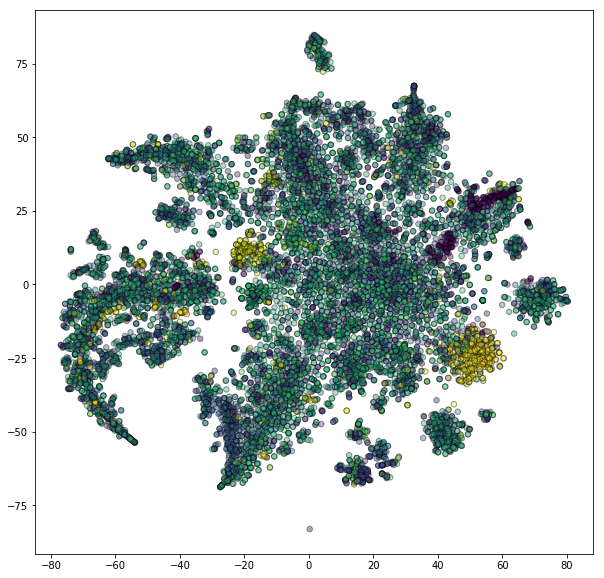

In [100]:
plt.figure(figsize=(10,10))
colors = ["#BF7F3F", "#EECF13", "#054713", "#09EEF4", "#0930F4", "#060309", "#7B19DD", "#43FF7F", "#E51EB5",
         "#D3B0F6", "#696901", "#D10037"]

plt.scatter(all_x, all_y, alpha=0.4, c=kmeans.labels_,  marker='o', s=30, edgecolor="black");
plt.legend()

In [136]:
#compare_parties(all_df)
dem = all_df[all_df.Party == "Democratic"]
dem_releases = list(dem["Release"])


In [263]:
test = recent_df[recent_df.Cluster ==1]
test.Party.value_counts()

Republican    392
Democratic    136
Name: Party, dtype: int64

In [293]:
compare_parties(all_df)

array([[ 0.02839791]])

In [94]:
db = DBSCAN(eps=.1,metric="cosine").fit(list(recent_df.scores))

In [95]:
Counter(db.labels_)

Counter({-1: 6776,
         0: 6131,
         1: 9,
         2: 5,
         3: 112,
         4: 12,
         5: 8,
         6: 14,
         7: 17,
         8: 10,
         9: 5,
         10: 6,
         11: 5,
         12: 3,
         13: 8,
         14: 13,
         15: 6,
         16: 5,
         17: 5,
         18: 5,
         19: 5,
         20: 7,
         21: 5,
         22: 4,
         23: 5,
         24: 5,
         25: 16,
         26: 5,
         27: 11})

In [52]:
afp = AffinityPropagation().fit(list(recent_df.scores))

In [62]:
Counter(afp.labels_)

Counter({0: 19,
         1: 32,
         2: 17,
         3: 31,
         4: 1,
         5: 18,
         6: 17,
         7: 4,
         8: 5,
         9: 21,
         10: 104,
         11: 35,
         12: 22,
         13: 19,
         14: 35,
         15: 81,
         16: 120,
         17: 7,
         18: 36,
         19: 1,
         20: 67,
         21: 28,
         22: 129,
         23: 42,
         24: 75,
         25: 55,
         26: 1,
         27: 14,
         28: 19,
         29: 28,
         30: 66,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 122,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 24,
         50: 1,
         51: 1,
         52: 137,
         53: 4,
         54: 2,
         55: 86,
         56: 16,
         57: 1,
         58: 9,
         59: 13,
         60: 4

In [474]:
comm_scores_year = get_all_committee_year_scores(recent_df)

Agriculture 2017
Agriculture 2016
Agriculture 2015
Agriculture 2014
Agriculture 2013
Agriculture 2012
Appropriations 2017
Appropriations 2016
Appropriations 2015
Appropriations 2014
Banking 2017
Banking 2016
Banking 2015
Banking 2014
Banking 2013
Banking 2012
Budget 2017
Budget 2016
Budget 2015
Budget 2014
Budget 2013
Budget 2012
Commerce 2012
Commerce 2013
Commerce 2014
Commerce 2015
Commerce 2016
Commerce 2017
Finance 2017
Finance 2016
Finance 2015
Finance 2014
Finance 2013
Finance 2012
Foreign Relations 2017
Foreign Relations 2016
Foreign Relations 2015
Foreign Relations 2014
Foreign Relations 2013
Foreign Relations 2012
HELP 2017
HELP 2016
HELP 2015
HELP 2014
HELP 2013
HELP 2012
Small Business 2017
Small Business 2016
Small Business 2015
Small Business 2014
Small Business 2013
Small Business 2012
Environment 2017
Environment 2016
Environment 2015
Environment 2014
Environment 2013
Environment 2012
Energy 2012
Energy 2013
Energy 2014
Energy 2015
Energy 2016
Energy 2017
Homeland Secur

In [476]:
rows = list()
for arr in comm_scores_year.items():
    comm = arr[0][0]
    year = arr[0][1]
    score = arr[1]
    row = [comm, year, score]
    rows.append(row)

comm_scores_year_df = pd.DataFrame(rows, columns=["Committee", "Year", "Score"])

In [483]:
recent_df[(recent_df.Committee == "Appropriations") & (recent_df.Year == 2015)].Party.value_counts()

Republican    111
Democratic     68
Name: Party, dtype: int64

In [508]:
x = comm_scores_year_df[comm_scores_year_df.Year == 2013].sort_values("Score", ascending=False).reset_index().drop("index", axis=1)

In [509]:
x

Committee  Year     Score
0              Budget  2013  0.277822
1         Agriculture  2013  0.170916
2         Environment  2013  0.164675
3            Commerce  2013  0.132442
4   Homeland Security  2013  0.122096
5                HELP  2013  0.105737
6             Banking  2013  0.093465
7   Foreign Relations  2013  0.088542
8             Finance  2013  0.061421
9      Small Business  2013  0.050314
10             Energy  2013  0.025116

In [510]:
rankings_dict = defaultdict(list)
for year in range(2012, 2018):
    df = comm_scores_year_df[comm_scores_year_df.Year == year].sort_values("Score", ascending=False).reset_index().drop("index", axis=1)
    for comm in committees:
        try:
            num = df.index[df.Committee == comm].tolist()[0] + 1
            rankings_dict[comm].append(num)
        except:
            rankings_dict[comm].append(None)

In [515]:
rows = list()
for i in rankings_dict.items():
    comm = i[0]
    a = i[1][0]
    b = i[1][1]
    c = i[1][2]
    d = i[1][3]
    e = i[1][4]
    f = i[1][5]
    row = [comm, a, b, c, d, e, f]
    rows.append(row)
rankings_df = pd.DataFrame(rows, columns=["Committee", "2012", "2013", "2014", "2015", "2016", "2017"])

In [516]:
rankings_df

Committee  2012  2013  2014  2015  2016  2017
0         Agriculture   4.0   2.0     2     2     3     3
1      Appropriations   NaN   NaN     1     1     6     4
2             Banking   NaN   7.0    10     3     7     7
3              Budget   2.0   1.0     4     7     4     2
4            Commerce   5.0   4.0    11     4     1     1
5             Finance   NaN   9.0    12    10     9     6
6   Foreign Relations   1.0   8.0     6     6     5    11
7                HELP   6.0   6.0     7     8    11    10
8      Small Business   8.0  10.0     3    12     8    12
9         Environment   3.0   3.0     9     5     2     9
10             Energy   7.0  11.0     5     9    12     5
11  Homeland Security   9.0   5.0     8    11    10     8

Consistently Higher Cosine Distance--Agriculture, Appropriations, Budget, Commerce
Consistently Lower Cosine Distance--Small Business, Homeland Security, Finance, HELP, Energy
Varies -- Banking, Foreign Relations, Environment

Agriculture--High Distance, Low Partisan

Appropriations--High Distance, Low Partisanship

Banking--Low Distance, High Partisan

Budget--Low Distance, High Partisan

Commerce--High Disance, Low Partisan

Finance--High Distance, High Partisan

Environment--Low Distance, High Partisan

Energy--Low Disatance, Low Partisan

FR --Low Distance, Low Partisan

HELP-- Low Distance, High Partisan

Homeland Security -- Low Distance, High Partisan

Small Business -- Low Distance, Low Partisan

## Foreign Relations <a class="anchor" id="foreign_relations"></a>

In [20]:
fr_df = all_df[all_df.Committee == "Foreign Relations"]
dem_fr = fr_df[fr_df.Party == "Democratic"]
rep_fr = fr_df[fr_df.Party == "Republican"]

In [27]:
pd.DataFrame(fr_df.groupby(["Party", "Committee"], as_index=False)["Release"].agg(lambda col: " ".join(col))).iloc[1]

Party                                               Republican
Committee                                    Foreign Relations
Release       WASHINGTON – The Senate Foreign Relations Com...
Name: 1, dtype: object

In [316]:
compare_parties(fr_df)

array([[ 0.09375304]])

In [105]:
dem_fr_scores = get_rel_average(list(dem_fr["Release"]))
rep_fr_scores = get_rel_average(list(rep_fr["Release"]))

In [133]:
y = get_rel_average(list(dem_fr["Release"]))
y[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([  1.09346993e-02,   5.26360332e-03,   1.27315705e-01,
         2.06491445e-01,   8.30959844e-02,   2.46052845e-03,
         3.13979545e-02,   4.57482878e-02,   7.41226160e-02,
         1.07195811e-03,   1.44235352e-04,   9.16711020e-02,
         2.32193683e-04,   1.38666774e-01,   6.53252612e-03,
         2.19528598e-03,   1.43400016e-01,   4.09242313e-04,
         5.19328480e-03,   4.92285999e-03,   1.56044762e-04,
         3.69403359e-02,   9.16659559e-02,   2.50074596e-02,
         5.99331634e-03,   1.15385495e-03,   7.58869121e-02,
         3.30475476e-04,   4.92355013e-02,   6.48502758e-03,
         6.83779772e-04,   3.83265664e-04,   2.54907781e-02,
         1.70093196e-03,   1.48737772e-04,   0.00000000e+00,
         2.66702408e-04,   8.31991127e-05,   8.21720062e-02,
         2.26454196e-04,   1.60962591e-03,   0.00000000e+00,
         3.55568839e-04,   9.13094001e-04,   0.00000000e+00,
         0.00000000e+00,   1.20965325e-01,   7.54888189e-04,
         1.82585069e-03,

In [539]:
df = recent_df.groupby(["Committee", "Party", "Year"], as_index=False)["Topic_Scores"].apply(list)
df

Committee          Party       Year
Agriculture        Democratic  2012    [[0.0464397530715, 0.287111660402, 0.004043277...
                               2013    [[0.034035796144, 0.014539782789, 0.8844980255...
                               2014    [[0.115678956037, 0.0130245057884, 0.210000389...
                               2015    [[0.0203931546876, 0.000421211148445, 0.159658...
                               2016    [[0.0946623757154, 0.0, 0.34576711062, 0.0, 0....
                               2017    [[0.0263604156401, 0.0355500024226, 0.12978190...
                   Republican  2012    [[0.00977981391023, 0.0, 0.518874699819, 0.012...
                               2013    [[3.15534348246e-05, 0.0, 0.146134127479, 0.01...
                               2014    [[0.01587627338, 0.00522369643519, 0.160427852...
                               2015    [[0.0, 0.00553015408602, 0.00108802273528, 0.0...
                               2016    [[0.0356186453972, 0.0, 0.201252060

In [529]:
pd.DataFrame(df)

0
Committee         Year                                                   
Agriculture       2012  [[0.0464397530715, 0.287111660402, 0.004043277...
                  2013  [[0.034035796144, 0.014539782789, 0.8844980255...
                  2014  [[0.115678956037, 0.0130245057884, 0.210000389...
                  2015  [[0.0203931546876, 0.000421211148445, 0.159658...
                  2016  [[0.0946623757154, 0.0, 0.34576711062, 0.0, 0....
                  2017  [[0.0263604156401, 0.0355500024226, 0.12978190...
Appropriations    2014  [[0.00619695749451, 0.000634042884404, 0.08912...
                  2015  [[0.0, 0.0212717390872, 0.0118108836394, 0.0, ...
                  2016  [[0.00376066205585, 0.135343330319, 0.00908815...
                  2017  [[0.0215894702579, 0.510388397482, 0.007255934...
Banking           2012  [[0.0107260836687, 0.0259741491886, 0.02582299...
                  2013  [[2.49181984776, 0.15650887513, 0.153887234672...
                  2014  [[0.00685611903562, 0.00106934013586, 0.006104...
                  2015  [[0.00158065900411, 0.00104192050091, 0.092049...
                  2016  [[0.0140813326436, 0.000864057574208, 0.013262...
                  2017  [[0.0353114220252, 1.38545800361, 0.0004972796...
Budget            2012  [[0.0152638606085, 0.000995921677227, 0.212670...
                  2013  [[0.00237509643947, 0.00623004826469, 0.001341...
                  2014  [[0.0215882939373, 0.0811175575427, 0.17840385...
                  2015  [[0.0157601469745, 0.0183296468512, 0.00142258...
                  2016  [[1.94222098992, 0.0, 0.000711113423486, 0.001...
                  2017  [[0.0117833673939, 0.188608887288, 0.013526189...
Commerce          2012  [[0.0122003517721, 0.0174083561096, 0.00549833...
                  2013  [[0.0630284507191, 0.00187935216443, 0.0033067...
                  2014  [[0.00394496884675, 0.0275228217354, 0.0249250...
                  2015  [[0.00405945652643, 1.80177449144e-05, 0.02903...
                  2016  [[2.19296795522, 0.0787384420512, 0.0010976414...
                  2017  [[2.78333351758, 0.0375280003769, 0.3487820906...
Energy            2012  [[0.0228910677991, 0.00428022653013, 0.0008294...
                  2013  [[2.6744814144e-05, 0.0191991771596, 0.0, 0.00...
...                                                                   ...
Finance           2012  [[0.0186812716256, 0.00776690366678, 0.0229116...
                  2013  [[0.0350545230986, 0.00931877600184, 0.4074737...
                  2014  [[3.03627158664, 0.0095258060239, 0.0008724317...
                  2015  [[0.051568222285, 0.0257290791834, 0.217779359...
                  2016  [[0.00127490309612, 5.65296508473e-05, 0.00698...
                  2017  [[0.0448129049993, 0.000943309721069, 0.399914...
Foreign Relations 2012  [[0.000938045288193, 0.480151853187, 0.1837987...
                  2013  [[0.0392060522687, 0.0, 0.0, 0.00185346016662,...
                  2014  [[0.307233094884, 0.0, 0.000230541205241, 0.00...
                  2015  [[0.0107911903885, 0.00818092601674, 0.0490299...
                  2016  [[0.265106174987, 0.00573485215316, 0.15811970...
                  2017  [[0.0177190729967, 0.00744694644657, 0.0, 0.18...
HELP              2012  [[0.0126582005234, 0.370476182664, 0.177409172...
                  2013  [[0.0192240502625, 0.638925367482, 0.217971115...
                  2014  [[0.0086238562377, 0.910332282782, 0.051168163...
                  2015  [[0.0676018977941, 0.331140723781, 0.422025000...
                  2016  [[0.00510773779839, 0.0675186715317, 0.0019990...
                  2017  [[0.0108895088761, 0.198868327705, 0.029048808...
Homeland Security 2012  [[5.52817797831, 0.0169478066524, 0.0, 0.00076...
                  2013  [[0.00262182986175, 0.0276040934046, 0.2431881...
                  2014  [[0.00384924701973, 0.012539781754, 0.31693561...
                  2015  [[0.0303962149571, 0.135632410963, 0.001832491...
  

In [126]:
dem_fr_scores

array([ 0.04867546,  0.04075747,  0.07759608,  0.04233207,  0.02044419,
        0.02867035,  0.03531035,  0.04981336,  0.04922244,  0.03017634,
        0.03124632,  0.04280059,  0.03157356,  0.02275051,  0.00748383,
        0.04871278,  0.0290744 ,  0.00169432,  0.00527825,  0.00669659,
        0.01069791,  0.04711194,  0.01879179,  0.01429104,  0.00772005,
        0.00903421,  0.02433852,  0.00868107,  0.01995996,  0.00927079,
        0.01684374,  0.02948088,  0.00963734,  0.00703449,  0.00986784,
        0.00695043,  0.01013229,  0.00343228,  0.01760416,  0.01781617,
        0.00671641,  0.01388131,  0.00558879,  0.02075885,  0.01277524,
        0.01202878,  0.02218773,  0.00838659,  0.00768615,  0.0096409 ,
        0.00831516,  0.00447308,  0.00529753,  0.00513658,  0.01236587,
        0.02072264,  0.00634943,  0.09318915,  0.04076915,  0.00804265,
        0.00778574,  0.01465412,  0.0024848 ,  0.00847498,  0.00276713,
        0.02045156,  0.0312231 ,  0.00504633,  0.01655615,  0.00

In [107]:
pairwise_distances(dem_fr_scores.reshape(1,-1), rep_fr_scores.reshape(1,-1), metric="cosine")

array([[ 0.09375304]])

In [180]:
compare_parties(fr_df)

array([[ 0.09375304]])

In [88]:
dem_fr_scores.argsort()[-5:]

array([ 2,  1, 57,  4,  0])

In [87]:
rep_fr_scores.argsort()[-5:]

array([74,  1, 57,  4,  0])

/home/dgilberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/dgilberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


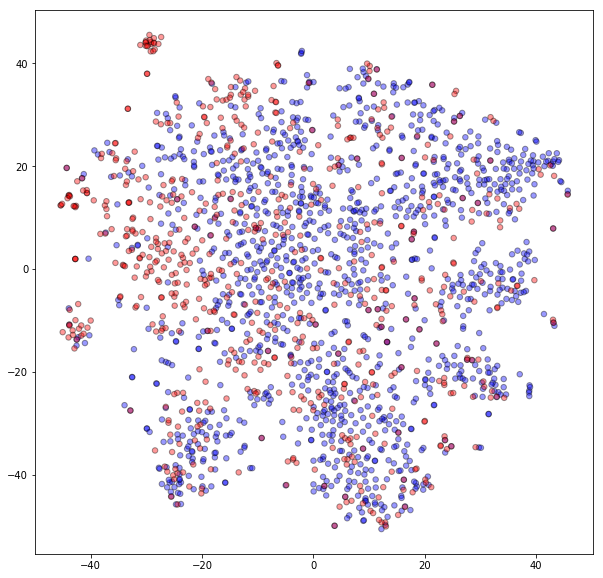

In [96]:
fr_tsne = TSNE(n_components=2)

fr_scores = get_all_rel_scores(list(fr_df.Release))

fr_scores = pd.DataFrame(fr_scores)

fr_results = fr_tsne.fit_transform(fr_scores)

fr_df["Party_Classification"] = fr_df.apply(lambda row: get_party_classification(row["Party"]), axis=1)
fr_x, fr_y = get_coords(fr_results)

plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(fr_x, fr_y, alpha=0.4, c=colors[fr_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

## Commerce <a class="anchor" id="commerce"></a>

In [142]:
comm_df = all_df[all_df.Committee == "Commerce"]
dem_comm = comm_df[comm_df.Party == "Democratic"]
rep_comm = comm_df[comm_df.Party == "Republican"]

In [314]:
compare_parties(comm_df)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [98]:
dem_comm_scores = get_rel_average(list(dem_comm["Release"]))
rep_comm_scores = get_rel_average(list(rep_comm["Release"]))

In [99]:
pairwise_distances(dem_comm_scores.reshape(1,-1), rep_comm_scores.reshape(1,-1), metric="cosine")

array([[ 0.08519327]])

In [52]:
rep_comm_scores.argmax()

25

In [56]:
rep_comm_scores.argsort()[-5:]

array([ 4,  6, 52, 12, 25])

In [57]:
dem_comm_scores.argsort()[-5:]

array([56,  2,  0,  4, 25])

/home/dgilberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/dgilberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


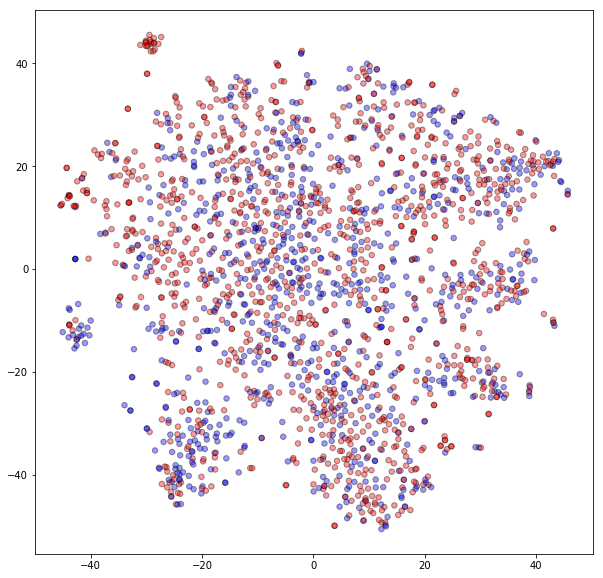

In [100]:
comm_tsne = TSNE(n_components=2)

comm_scores = get_all_rel_scores(list(comm_df.Release))

comm_scores = pd.DataFrame(comm_scores)

comm_results = comm_tsne.fit_transform(comm_scores)

comm_df["Party_Classification"] = comm_df.apply(lambda row: get_party_classification(row["Party"]), axis=1)
comm_x, comm_y = get_coords(comm_results)

plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(fr_x, fr_y, alpha=0.4, c=colors[comm_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

In [147]:
compare_parties(comm_df)

array([[ 0.10787293]])

## Agriculture <a class="anchor" id="agriculture"></a>

In [148]:
ag_df = all_df[all_df.Committee == "Agriculture"]

In [312]:
df = get_rel_average(list(ag_df.Release))
cols  = list()
for i in range(1,101):
    test = str(i)
    cols.append("ag" + test)
    
df.columns = cols
df.mean()

ag1       ag2       ag3       ag4       ag5       ag6       ag7  \
0    0.001501  0.004759  0.009963  0.008844  0.005342  0.013944  0.000796   
1    0.012812  0.009335  0.048585  0.004897  0.012433  0.000718  0.003428   
2    0.001969  0.001501  0.000000  0.006681  0.295192  0.000034  0.001204   
3    0.268470  0.005047  0.212695  0.005865  0.003369  0.013322  0.000121   
4    0.086162  0.000249  0.079950  0.004725  0.111321  0.008348  0.112347   
5    0.138292  0.013974  0.002172  0.003014  0.003315  0.041916  0.000739   
6    0.004046  0.005242  0.001400  0.005671  0.002344  0.103598  0.000925   
7    0.000533  0.001499  0.001603  0.115057  0.006601  0.006135  0.000644   
8    0.100660  0.015330  0.002071  0.005380  0.005594  0.189193  0.000375   
9    0.039630  0.000000  0.000000  0.003224  0.031589  0.007191  0.000000   
10   0.002497  0.000000  0.002118  0.000836  0.004372  0.000000  0.066865   
11   0.006391  0.002103  0.011244  0.154061  0.010354  0.057475  0.001673   
12   0.130008  0.329234  0.156120  0.058158  0.006705  0.006236  0.030305   
13   0.006266  0.000310  0.011118  0.001931  0.000822  0.125035  0.001239   
14   0.007114  0.004626  0.001871  0.005470  0.006551  0.248880  0.000695   
15   0.000000  0.002174  0.001044  0.181964  0.000945  0.109162  0.000215   
16   0.004903  0.004184  0.014380  0.004148  0.004118  0.010177  0.003256   
17   0.003209  0.001302  0.000559  0.106587  0.001574  0.002789  0.000299   
18   0.000000  0.491263  0.707172  0.006112  0.002218  0.007930  0.000000   
19   0.001685  0.003698  0.000452  0.006000  0.000808  0.074831  0.001757   
20   0.011261  0.032398  0.000940  0.005342  0.000427  0.005067  0.002573   
21   0.530743  0.004654  0.001223  0.005031  0.006318  0.040497  0.001263   
22   0.007084  0.181788  0.287205  0.009132  0.008033  0.005987  0.000671   
23   0.000000  0.000000  0.000000  0.011262  0.002963  0.012432  0.000058   
24   0.000157  0.001230  0.002279  0.016800  0.113865  0.000878  0.127614   
25   0.015767  0.002147  0.048475  0.048427  0.002903  0.004300  0.034863   
26   0.003899  0.002674  0.118495  0.010449  0.083066  0.008590  0.000641   
27   0.000000  0.006976  0.000000  0.008928  0.010882  0.018958  0.001327   
28   0.277600  0.016700  0.002993  0.005628  0.005083  0.082235  0.001016   
29   0.141813  0.017085  0.114615  0.146171  0.003498  0.037645  0.001167   
..        ...       ...       ...       ...       ...       ...       ...   
634  0.001088  0.013255  0.007863  0.002020  0.001254  0.047385  0.000662   
635  0.004908  0.136829  0.007966  0.043139  0.009962  0.002266  0.024591   
636  0.002552  0.019294  0.000114  0.002407  0.015252  0.000000  0.000228   
637  0.002539  0.018166  0.000152  0.000411  0.356438  0.000000  0.000177   
638  0.000020  0.005470  0.015108  0.258331  0.004150  0.000353  0.000000   
639  0.000494  0.015889  0.001411  0.003370  0.000000  0.000000  0.000242   
640  0.002188  0.011430  0.000650  0.000000  0.011609  0.000000  0.069657   
641  0.003714  0.013966  0.000000  0.000095  0.035823  0.000169  0.087641   
642  0.004053  0.029107  0.010773  0.001224  0.012159  0.000365  0.001547   
643  0.366642  0.000684  0.001411  0.005228  0.003994  0.003867  0.004149   
644  0.000489  0.003513  0.332844  0.169400  0.005461  0.002925  0.075482   
645  0.002646  0.003364  0.161204  0.006898  0.000507  0.000000  0.000237   
646  0.000000  0.169711  0.000000  0.004222  0.006220  0.010349  0.000000   
647  0.003035  0.124968  0.000212  0.070655  0.140124  0.041274  0.131101   
648  0.488299  0.005385  0.287839  0.005306  0.063892  0.000230  0.000423   
649  0.000998  0.002470  0.000227  0.001378  0.005420  0.000000  0.000000   
650  0.101332  0.001651  0.148007  0.000539  0.010713  0.051734  0.001061   
651  0.001926  0.002246  0.163480  0.001595  0.459807  0.259397  0.000055   
652  0.816745  0.000414  0.000249  0.000806  0.018891  0.003524  0.208411   
653  0.017251  0.002045  0.000476  0.005551  0.000464  0.000043  0.001295   
654  0

In [305]:
df.transpose().mean(axis=1)

0     0.056757
1     0.054461
2     0.056682
3     0.037278
4     0.038851
5     0.037589
6     0.048080
7     0.031882
8     0.078448
9     0.018826
10    0.019653
11    0.019958
12    0.009275
13    0.020071
14    0.019121
15    0.017203
16    0.023585
17    0.013313
18    0.020715
19    0.079916
20    0.011036
21    0.048432
22    0.014745
23    0.014203
24    0.010966
25    0.013205
26    0.014423
27    0.006371
28    0.024343
29    0.007403
        ...   
70    0.005975
71    0.001921
72    0.013446
73    0.008527
74    0.005121
75    0.003729
76    0.008784
77    0.015392
78    0.004914
79    0.003654
80    0.013123
81    0.010139
82    0.012338
83    0.006976
84    0.016027
85    0.010421
86    0.006949
87    0.010189
88    0.027093
89    0.012869
90    0.014018
91    0.009701
92    0.018900
93    0.011900
94    0.014588
95    0.018378
96    0.002994
97    0.004952
98    0.010665
99    0.003752
Length: 100, dtype: float64

## Finance

In [212]:
fin_df = all_df[all_df.Committee == "Finance"]

## Rank Committees <a class="anchor" id="rankings"></a>

In [264]:
committees = all_df.Committee.unique()

In [265]:
distances= defaultdict()
for com in committees:
    df = all_df[all_df.Committee == com]
    dist = compare_parties(df)
    distances[com] = dist[0]
    

In [266]:
distances


defaultdict(None,
            {'Agriculture': array([ 0.19683216]),
             'Appropriations': array([ 0.19254616]),
             'Banking': array([ 0.12133992]),
             'Budget': array([ 0.12726745]),
             'Commerce': array([ 0.09619779]),
             'Energy': array([ 0.06172582]),
             'Environment': array([ 0.10526714]),
             'Finance': array([ 0.26459741]),
             'Foreign Relations': array([ 0.07044983]),
             'HELP': array([ 0.06728722]),
             'Homeland Security': array([ 0.04490369]),
             'Small Business': array([ 0.01459882])})

## Testing <a class="anchor" id="testing"></a>

In [27]:
comm_dems = get_party_committee_score(all_df, "Democratic", "Commerce")
ag_rep = get_party_committee_score(all_df, "Republican", "Agriculture")

In [28]:
pairwise_distances(comm_dems.reshape(1,-1), ag_rep.reshape(1,-1), metric="cosine")

array([[ 0.3287505]])

In [221]:
comm_dems.argsort()[-5:]

array([ 1,  6, 24, 51,  0])

In [72]:
committees = list(all_df.Committee.unique())
committee_scores = defaultdict()
for i in committees:
    rep_score = get_party_committee_score(all_df, "Republican", i)
    dem_score = get_party_committee_score(all_df, "Democratic", i)
    rep_label = "Republican, " + i
    dem_label = "Democratic, " + i
    committee_scores[rep_label] = rep_score
    committee_scores[dem_label] = dem_score
    
committee_scores

defaultdict(None,
            {'Democratic, Agriculture': array([ 0.58437457,  0.05772204,  0.00717516,  0.19520973,  0.12390253,
                     0.04789081,  0.03735324,  0.01668351,  0.02128009,  0.03514221,
                     0.033979  ,  0.01978986,  0.06560026,  0.0078664 ,  0.05508897,
                     0.02781056,  0.02393928,  0.01699292,  0.01754136,  0.00464734,
                     0.01399862,  0.02332549,  0.00403884,  0.03289015,  0.00511395,
                     0.03541066,  0.04097641,  0.00556868,  0.00787922,  0.00711518,
                     0.02174891,  0.0348881 ,  0.01515658,  0.01907161,  0.01972697,
                     0.03287967,  0.02135893,  0.00473181,  0.03030141,  0.01187764,
                     0.01208373,  0.02748073,  0.00416502,  0.01162809,  0.00403905,
                     0.00483341,  0.03571138,  0.00663002,  0.00349905,  0.01103174,
                     0.01071127,  0.05066599,  0.0096322 ,  0.01543015,  0.00636041,
                    

In [70]:
warren = pd.read_pickle("/home/dgilberg/nlp_partisanship/data/senators/warren.pkl")
warren_rels = " ".join(list(warren["Release"]))
warren_scores = get_rel_score(warren_rels)

In [73]:
warren_dict = defaultdict()
warren_np = np.array(warren_scores)
for k, v in committee_scores.items():
    temp = pairwise_distances(warren_np.reshape(1,-1), v.reshape(1,-1), metric="cosine")
    warren_dict[k] = temp[0][0]
    
warren_sort = sorted(warren_dict.items(), key=lambda x: x[1])
[i for i in warren_sort if i[0].split(",")[0] == "Democratic"]

[('Democratic, Banking', 0.030309820485512673),
 ('Democratic, HELP', 0.039726566551300579),
 ('Democratic, Agriculture', 0.048710174421918939),
 ('Democratic, Finance', 0.067710475571004958),
 ('Democratic, Small Business', 0.10058397910212402),
 ('Democratic, Budget', 0.10589058062400758),
 ('Democratic, Energy', 0.14853865317319193),
 ('Democratic, Foreign Relations', 0.18889324034004307),
 ('Democratic, Environment', 0.26553912013476788),
 ('Democratic, Commerce', 0.30365657462698947),
 ('Democratic, Appropriations', 0.3687956034544726),
 ('Democratic, Homeland Security', 0.39154978318252165)]

In [31]:
year_scores = get_all_committee_year_scores(recent_df)
#sorted(mydict.iteritems(), key=lambda (k,v): (v,k))

Agriculture 2017
Agriculture 2016
Agriculture 2015
Agriculture 2014
Agriculture 2013
Agriculture 2012
Appropriations 2017
Appropriations 2016
Appropriations 2015
Appropriations 2014
Banking 2017
Banking 2016
Banking 2015
Banking 2014
Banking 2013
Banking 2012
Budget 2017
Budget 2016
Budget 2015
Budget 2014
Budget 2013
Budget 2012
Commerce 2012
Commerce 2013
Commerce 2014
Commerce 2015
Commerce 2016
Commerce 2017
Finance 2017
Finance 2016
Finance 2015
Finance 2014
Finance 2013
Finance 2012
Foreign Relations 2017
Foreign Relations 2016
Foreign Relations 2015
Foreign Relations 2014
Foreign Relations 2013
Foreign Relations 2012
HELP 2017
HELP 2016
HELP 2015
HELP 2014
HELP 2013
HELP 2012
Small Business 2017
Small Business 2016
Small Business 2015
Small Business 2014
Small Business 2013
Small Business 2012
Environment 2017
Environment 2016
Environment 2015
Environment 2014
Environment 2013
Environment 2012
Energy 2012
Energy 2013
Energy 2014
Energy 2015
Energy 2016
Energy 2017
Homeland Secur

In [32]:
year_scores_arr = list(year_scores.items())

In [33]:
sorted(year_scores_arr, key=lambda i: i[1], reverse=True)

[(('Foreign Relations', 2012), 0.53453230446338018),
 (('Budget', 2012), 0.4435700096245575),
 (('Appropriations', 2014), 0.43196969549609032),
 (('Agriculture', 2014), 0.39527996548913025),
 (('Commerce', 2017), 0.36552772160259395),
 (('Budget', 2017), 0.34573300488863212),
 (('Small Business', 2014), 0.32475950174817536),
 (('Commerce', 2016), 0.3060761907834848),
 (('Budget', 2013), 0.27782174486892486),
 (('Environment', 2016), 0.26096835435218446),
 (('Appropriations', 2015), 0.25656559354605346),
 (('Agriculture', 2016), 0.25381592239229889),
 (('Environment', 2012), 0.23644552002134478),
 (('Budget', 2016), 0.23065097204321694),
 (('Agriculture', 2015), 0.22946930971884305),
 (('Budget', 2014), 0.2276010582696909),
 (('Agriculture', 2012), 0.19871725173196431),
 (('Agriculture', 2017), 0.19534894579021922),
 (('Foreign Relations', 2016), 0.186047552722993),
 (('Agriculture', 2013), 0.17091637852428354),
 (('Energy', 2014), 0.16986053225724629),
 (('Banking', 2015), 0.1676901120

In [126]:
comm_quarter_scores = get_committee_distances_by_quarter(recent_df)

527
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [145]:
def get_three_most_divisive(df):
    df = df.sort_values("Score", ascending=False)
    

Committee  Year Quarter     Score
64    Budget  2012      Q1  0.445795
65    Budget  2012      Q2  0.000000
66    Budget  2012      Q3  0.000000
67    Budget  2012      Q4  0.000000
68    Budget  2013      Q1  0.235455
69    Budget  2013      Q2  0.526379
70    Budget  2013      Q3  0.561681
71    Budget  2013      Q4  0.358136
72    Budget  2014      Q1  0.235074
73    Budget  2014      Q2  0.362498
74    Budget  2014      Q3  0.249423
75    Budget  2014      Q4  0.458391
76    Budget  2015      Q1  0.214122
77    Budget  2015      Q2  0.366700
78    Budget  2015      Q3  0.724974
79    Budget  2015      Q4  0.751858
80    Budget  2016      Q1  0.682097
81    Budget  2016      Q2  0.000000
82    Budget  2016      Q3  0.209043
83    Budget  2016      Q4  0.000000
84    Budget  2017      Q1  0.739009
85    Budget  2017      Q2  0.687352
86    Budget  2017      Q3  0.642466
87    Budget  2017      Q4  0.000000

In [153]:
mask = (comm_quarter_scores.Year == 2012) & (comm_quarter_scores.Quarter == "Q3")
temp = comm_quarter_scores[mask].sort_values("Score", ascending=False)
list(comm_quarter_scores[mask]["Committee"])
temp[temp.Score != 0]

Committee  Year Quarter     Score
183  Foreign Relations  2012      Q3  0.543570
90            Commerce  2012      Q3  0.404888
2          Agriculture  2012      Q3  0.372330
136        Environment  2012      Q3  0.238430
207               HELP  2012      Q3  0.124109
114             Energy  2012      Q3  0.112979
231  Homeland Security  2012      Q3  0.018783

In [103]:
cand14 = joblib.load("2014.pkl")

In [132]:
cand14.iloc[107]["Platform"]

'Karen Handel in Survey of 2014 Senate campaign websites  On Abortion: Planned Bullyhood: book exposes Planned Parenthood\'s tactics Karen wrote the book Planned Bullyhood--the Truth Behind the Planned Parenthood Funding Battle. Karen, because of her pro-life beliefs, took the courageous step to stand up to the bully tactics of Planned Parenthood. She exposed the country\'s leading abortion provider as a liberal political machine willing to destroy anyone or any organization to advance its agenda and secure the continued flow of nearly $1.5 million a day in government funding to its coffers. Source: 2014 Senate campaign website www.karenhandel.com, "About" Jun 6, 2013 On Budget & Economy: Tenacious in balancing budget and dealing with corruption Karen was first elected in 2003 as Chairman of the Fulton County (Georgia) Board of Commissioners, and she quickly earned a reputation for tenacity in balancing the county\'s budget and dealing with corruption. Facing a $100 million budget defi

In [122]:
sasse = cand14.iloc[6]["Platform"]
sasse_scores = get_rel_score(sasse)

sasse_scores

In [127]:
test = recent_df[recent_df.Committee == "Homeland Security"]
test_releases = list(test.Release)
test_avg = get_rel_average(test_releases)

In [136]:
sasse_scores = np.array(sasse_scores)
pairwise_distances(test_avg.reshape(1,-1), sasse_scores.reshape(1,-1), metric="cosine")
committees = recent_df.Committee.unique()
sasse_coms = defaultdict()
for com in committees:
    temp = get_committee_average(recent_df, com)
    score = pairwise_distances(temp.reshape(1,-1), sasse_scores.reshape(1,-1), metric="cosine")
    sasse_coms[com] = score[0][0]

In [138]:
sorted(sasse_coms.items(), key=lambda x: x[1])

[('Homeland Security', 0.44450412967966346),
 ('Budget', 0.51012381670497242),
 ('HELP', 0.52431545202352958),
 ('Appropriations', 0.53000409641989177),
 ('Finance', 0.5417034453228049),
 ('Foreign Relations', 0.56023472066141622),
 ('Energy', 0.64060381023952173),
 ('Banking', 0.6520710159170704),
 ('Commerce', 0.65898355466073855),
 ('Agriculture', 0.68855129175007235),
 ('Environment', 0.69295545302468842),
 ('Small Business', 0.7528962614807353)]

In [44]:
committees = recent_df.Committee.unique()
for com in committees:
    df = all_df[all_df.Committee == com]
    print(com, list(df.Year.unique()))

Agriculture [2017, 2016, 2015, 2014, 2013, 2012, 2011]
Appropriations [2017, 2016, 2015, 2014]
Banking [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
Budget [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2003, 2002, 2001]
Commerce [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Finance [2017, 2016, 2015, 2014, 2013, 2012]
Foreign Relations [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009]
HELP [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
Small Business [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
Environment [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
Energy [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Homeland Security [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


In [61]:
temp = recent_df.groupby(["Committee", "Year", "Quarter", "Party"], as_index=False)["Release"].agg(lambda col: " ".join(col))
all_quarters = list(zip(list(temp.Committee), list(temp.Year), list(temp.Quarter), list(temp.Party)))

## Senator Testing

In [139]:
sullivan14 = joblib.load("sullivan14site.pkl")

In [144]:
sull_score =get_rel_score(sullivan14)
sull_score = np.array(sull_score)

In [145]:
sull_coms = defaultdict()
for com in committees:
    temp = get_committee_average(recent_df, com)
    score = pairwise_distances(temp.reshape(1,-1), sull_score.reshape(1,-1), metric="cosine")
    sull_coms[com] = score[0][0]

In [146]:
sull_coms

defaultdict(None,
            {'Agriculture': 0.6779017342387148,
             'Appropriations': 0.56187278298520638,
             'Banking': 0.66617595571844412,
             'Budget': 0.61073525720987298,
             'Commerce': 0.67134382485354704,
             'Energy': 0.46400472154464845,
             'Environment': 0.64837459960178812,
             'Finance': 0.59560999884954002,
             'Foreign Relations': 0.52662081680181427,
             'HELP': 0.56786529279393017,
             'Homeland Security': 0.51984250554647105,
             'Small Business': 0.72332532369756497})

## Visuals <a class="anchor" id="visuals"></a>

In [284]:
def get_chart_color(party, comm, committee):
    if party == "Democratic" and comm == committee:
        return "#191970"
    elif party == "Republican" and comm == committee:
        return "#800000"
    else:
        return "w"
    


In [285]:
def get_chart_label(party, comm, committee):
    if comm == committee:
        return party + ", " + comm
    else:
        return "Other"

In [518]:
def get_party_color(party):
    if party =="Democratic":
        return "#191970"
    elif party == "Republican":
        return "#800000"
    else:
        return "w"

In [249]:
budget_tsne_df = recent_df
budget_tsne_df["Color"] = budget_tsne_df.apply(lambda row: get_budget_chart_color(row["Party"], row["Committee"], "Budget"), axis=1)

/home/dgilberg/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


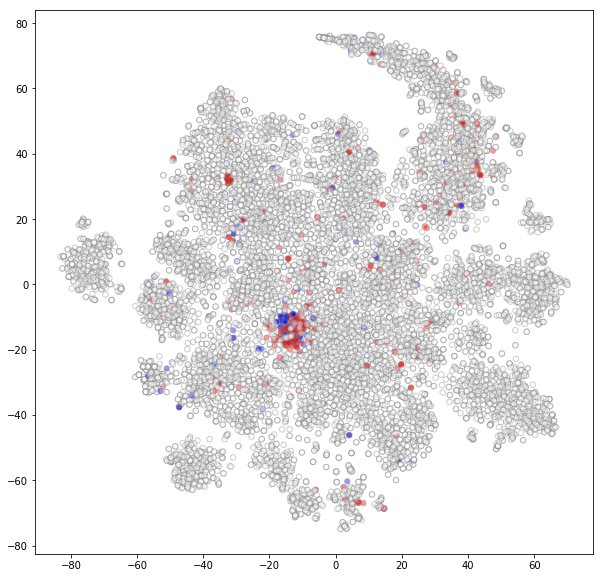

In [251]:
budget_tsne = TSNE(n_components=2)

budget_releases = list(budget_tsne_df.Release)
budget_scores = list(budget_tsne_df.Topic_Scores)
budget_scores_df = pd.DataFrame(budget_scores)

budget_results = budget_tsne.fit_transform(budget_scores_df)

bud_x, bud_y = get_coords(budget_results)

plt.figure(figsize=(10,10))
colors = list(budget_tsne_df.Color)

plt.scatter(bud_x, bud_y, alpha=0.4, c=colors,  marker='o', s=30, edgecolor="gray");
plt.legend()

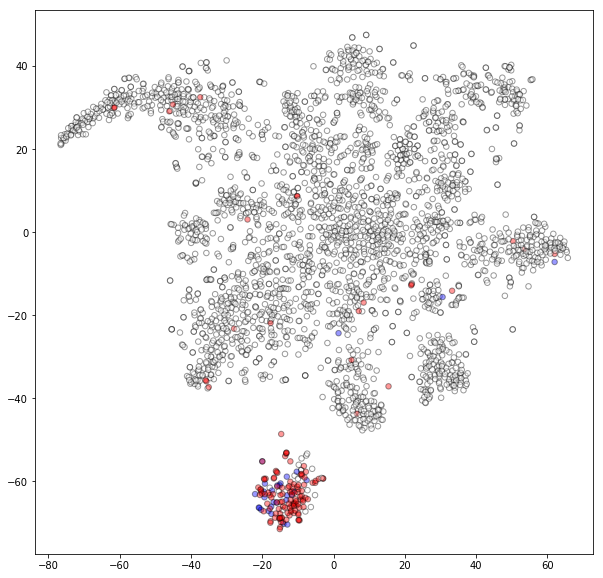

In [263]:
sb16_tsne_df = recent_df[recent_df.Year == 2015]
sb16_tsne_df["Color"] = sb16_tsne_df.apply(lambda row: get_budget_chart_color(row["Party"], row["Committee"], "Small Business"), axis=1)

sb16_tsne = TSNE(n_components=2)

sb16_releases = list(sb16_tsne_df.Release)
sb16_scores = list(sb16_tsne_df.Topic_Scores)
sb16_scores_df = pd.DataFrame(sb16_scores)

sb16_results = sb16_tsne.fit_transform(sb16_scores_df)

sb16_x, sb16_y = get_coords(sb16_results)

plt.figure(figsize=(10,10))
colors = list(sb16_tsne_df.Color)

plt.scatter(sb16_x, sb16_y, alpha=0.4, c=colors,  marker='o', s=30, edgecolor="black");
plt.legend()

In [328]:
def plot_tsne_committee_year(df, committee, year):
    temp = df[df.Year == year]
    temp["Color"] = temp.apply(lambda row: get_chart_color(row["Party"], row["Committee"], committee), axis=1)
    
    temp_tsne = TSNE(n_components=2)
    temp_releases = list(temp.Release)
    temp_scores = list(temp.Topic_Scores)
    temp_scores_df = pd.DataFrame(temp_scores)

    temp_results = temp_tsne.fit_transform(temp_scores_df)

    x, y = get_coords(temp_results)

    plt.figure(figsize=(8,8))
    colors = list(temp.Color)

    plt.scatter(x, y, alpha=0.4, c=colors,  marker='o', s=30, edgecolor="gray");
    title_str = "{} Cosine Distances in {}".format(committee, str(year))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    plt.title(title_str)
    plt.legend(loc=4)

In [331]:
tsne

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

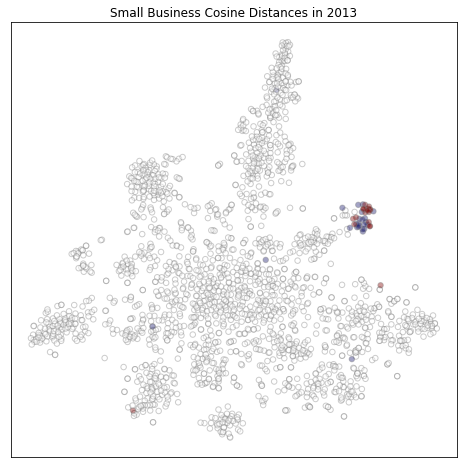

In [360]:
plot_tsne_committee_year(recent_df, "Small Business", 2013)

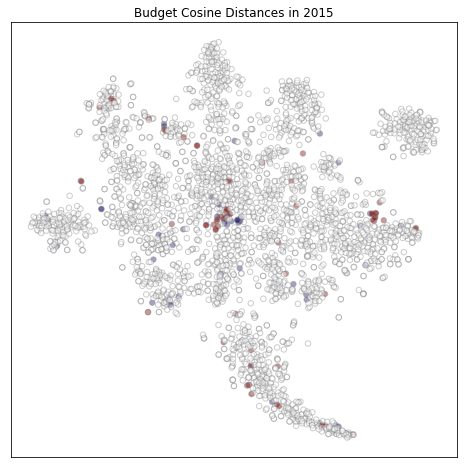

In [330]:
plot_tsne_committee_year(recent_df, "Budget", 2015)

TSNE of all my results, find indexes of colors

In [287]:
bud16_tsne_df = recent_df[recent_df.Year == 2015]
bud16_tsne_df["Color"] = bud16_tsne_df.apply(lambda row: get_budget_chart_color(row["Party"], row["Committee"], "Budget"), axis=1)
bud16_tsne_df["Chart_Label"] = bud16_tsne_df.apply(lambda row: get_chart_label(row["Party"], row["Committee"], "Budget"), axis=1)

In [ ]:
bud16_tsne = TSNE(n_components=2)

bud16_releases = list(bud16_tsne_df.Release)
bud16_scores = list(bud16_tsne_df.Topic_Scores)
bud16_scores_df = pd.DataFrame(bud16_scores)

bud16_results = bud16_tsne.fit_transform(bud16_scores_df)

bud16_x, bud16_y = get_coords(bud16_results)

In [ ]:
# fig, ax = plt.subplots()
# for color in ['red', 'green', 'blue']:
#     n = 750
#     x, y = rand(2, n)
#     scale = 200.0 * rand(n)
#     ax.scatter(x, y, c=color, s=scale, label=color,
#                alpha=0.3, edgecolors='none')

# ax.legend()
# ax.grid(True)

In [ ]:
# def plot_tsne_committee_year(df, committee, year):
#     temp = df[df.Year == year]
#     df["Color"] = df.apply(lambda row: get_chart_color(row["Party"], row["Committee"], committee), axis=1)
    
#     temp_tsne = TSNE(n_components=2)
#     temp_releases = list(temp.Release)
#     temp_scores = list(temp.Topic_Scores)
#     temp_scores_df = pd.DataFrame(temp_scores)

#     temp_results = temp_tsne.fit_transform(temp_scores_df)

#     x, y = get_coords(temp_results)

#     plt.figure(figsize=(10,10))
#     colors = list(temp.Color)

#     plt.scatter(x, y, alpha=0.4, c=colors,  marker='o', s=30, edgecolor="black");
#     title_str = "{} Cosine Distances in {}".format(committee, str(year))
#     plt.title(title_str)
#     plt.legend(loc=4)

In [385]:
df16 = recent_df[recent_df.Year == 2016].reset_index()
tsne16 = TSNE(n_components = 2)
rels16 = list(df16.Release)
scores16 = list(df16.Topic_Scores)
scores16_df = pd.DataFrame(scores16)
results16 = tsne16.fit_transform(scores16_df)
x16, y16 = get_coords(results16)

In [384]:
len(df16)

2219

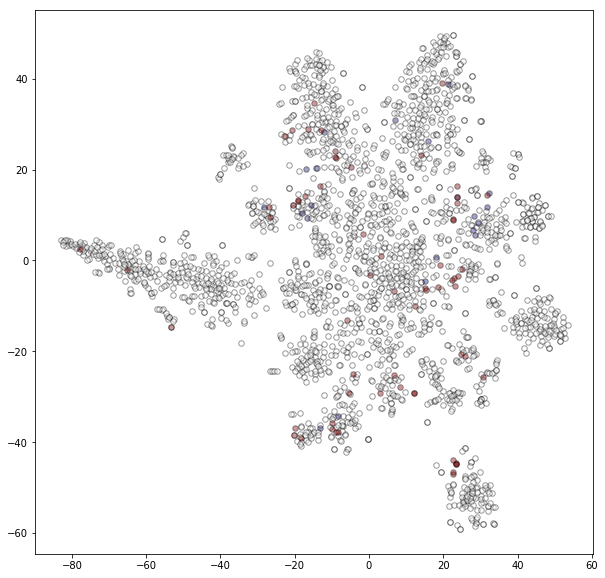

In [398]:
plt.figure(figsize=(10,10))
df16["Color"] = df16.apply(lambda row: get_chart_color(row["Party"], row["Committee"], "Agriculture"), axis=1)

colors = list(df16.Color)
arr = ['w','#191970', '#800000']
for i in arr:
    indexes = list(df16.index[df16.Color == i])
    x_plot = list()
    y_plot = list()
    for j in indexes:
        x_plot.append(x16[j])
        y_plot.append(y16[j])
    plt.scatter(x_plot, y_plot, alpha=0.4, c=i,  marker='o', s=30, edgecolor="black")

In [ ]:
df15 = recent_df[recent_df.Year == 2015].reset_index()
tsne15 = TSNE(n_components = 2)
rels15 = list(df15.Release)
scores15 = list(df15.Topic_Scores)
scores15_df = pd.DataFrame(scores15)
results15 = tsne16.fit_transform(scores15_df)
x15, y15 = get_coords(results15)

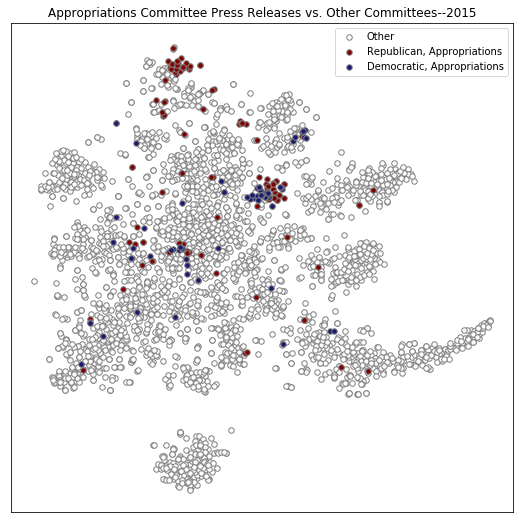

In [484]:
plt.figure(figsize=(9,9))
committee = "Appropriations"
df15["Color"] = df15.apply(lambda row: get_chart_color(row["Party"], row["Committee"], committee), axis=1)
arr = ['w', '#800000', '#191970']
for i in arr:
    indexes = list(df15.index[df15.Color == i])
    x_plot = list()
    y_plot = list()
    comm_dict = {'w': "Other", '#800000': "Republican, {}".format(committee), '#191970': "Democratic, {}".format(committee)}
    for j in indexes:
        x_plot.append(x15[j])
        y_plot.append(y15[j])
    plt.scatter(x_plot, y_plot, alpha=1.0, c=i,  marker='o', s=30, edgecolor="grey", label=comm_dict[i])

plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
plt.legend()
plt.title("{} Committee Press Releases vs. Other Committees--2015".format(committee));

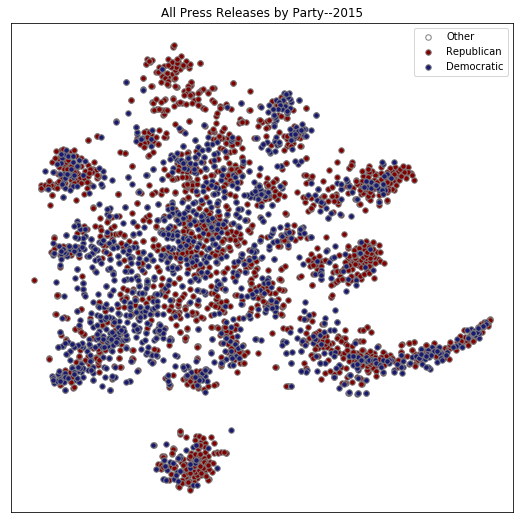

In [521]:
plt.figure(figsize=(9,9))
committee = "Appropriations"
temp = df15
temp["Color"] = temp.apply(lambda row: get_party_color(row["Party"]), axis=1)
colors = list(temp.Color)
arr = ['w', '#800000', '#191970']
for i in arr:
    indexes = list(temp.index[df15.Color == i])
    x_plot = list()
    y_plot = list()
    comm_dict = {'w': "Other", '#800000': "Republican", '#191970': "Democratic"}
    for j in indexes:
        x_plot.append(x15[j])
        y_plot.append(y15[j])
    plt.scatter(x_plot, y_plot, alpha=1.0, c=i,  marker='o', s=30, edgecolor="grey", label=comm_dict[i])

plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
plt.legend()
plt.title("All Press Releases by Party--2015");

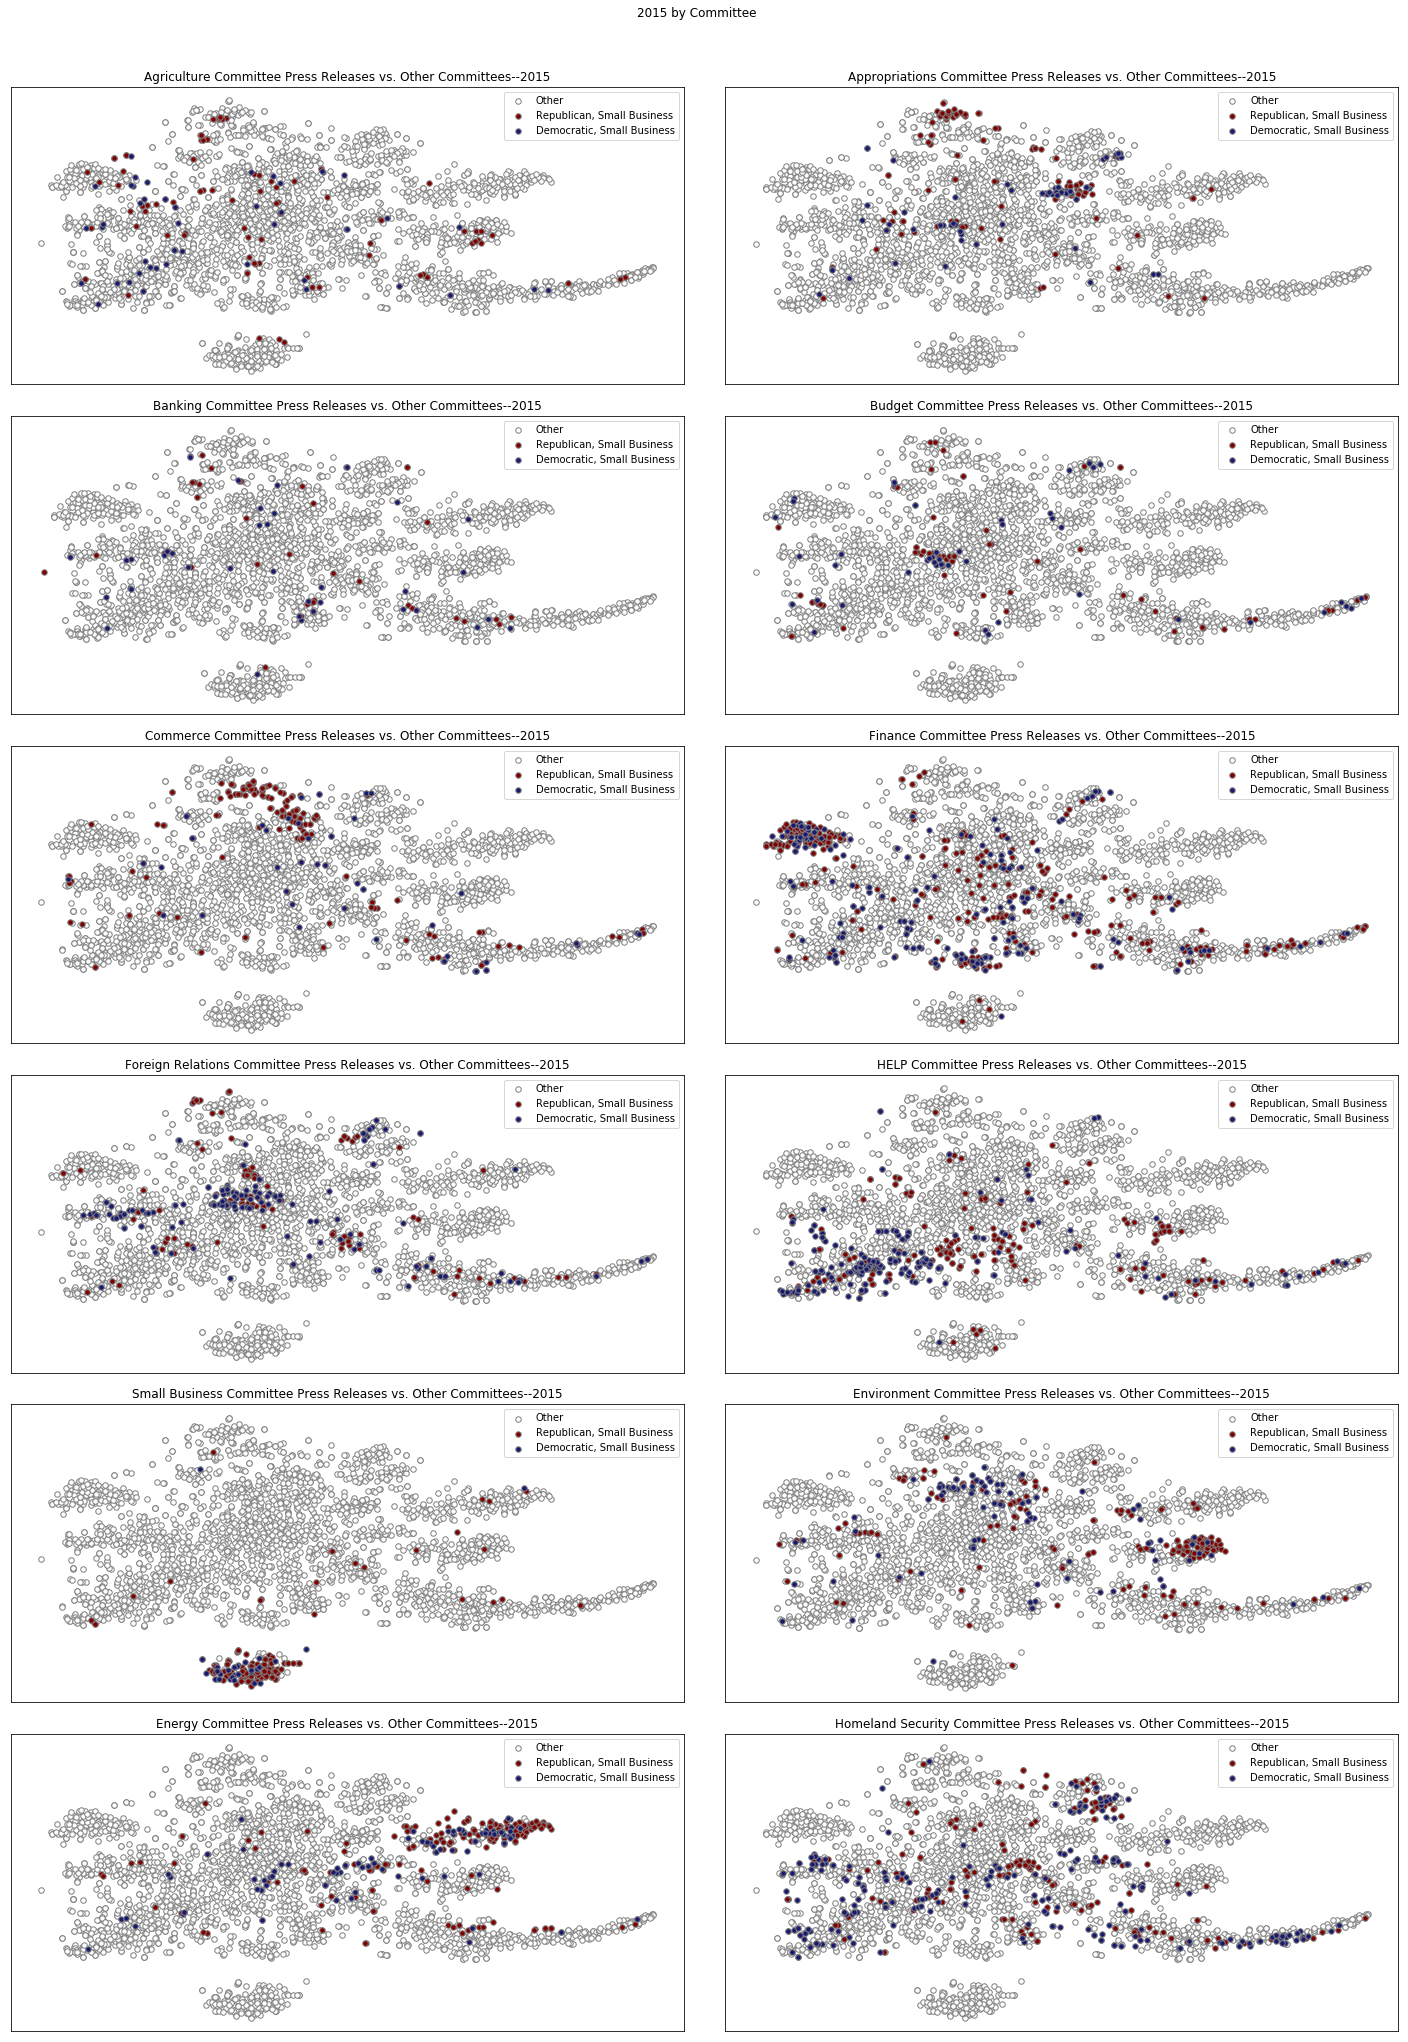

In [469]:
fig, axes = plt.subplots(6,2, figsize=(20,30))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
committees = list(recent_df.Committee.unique())
ax_dict = dict(zip(committees, axes.flatten()))
for comm in committees:
    ax = ax_dict[comm]
    df15["Color"] = df15.apply(lambda row: get_chart_color(row["Party"], row["Committee"], comm), axis=1)
    arr = ['w', '#800000', '#191970']
    for i in arr:
        indexes = list(df15.index[df15.Color == i])
        x_plot = list()
        y_plot = list()
        comm_dict = {'w': "Other", '#800000': "Republican, {}".format(committee), '#191970': "Democratic, {}".format(committee)}
        for j in indexes:
            x_plot.append(x15[j])
            y_plot.append(y15[j])
        ax.scatter(x_plot, y_plot, alpha=1.0, c=i,  marker='o', s=30, edgecolor="grey", label=comm_dict[i])

    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    ax.legend()
    plt_title = "{} Committee Press Releases vs. Other Committees--2015".format(comm)
    ax.set_title(plt_title);
    
plt.suptitle("2015 by Committee");
#plt.title("{} Committee Press Releases vs. Other Committees--2015".format(committee));